# Imports

In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns

from src.utils.configure_samplers import stan_nuts, drghmc, drhmc, ghmc
from src.utils.posteriors import get_posterior
from src.utils.summary_stats import processed_ref_draws
from src.utils.save_samples import grad_counter

%load_ext autoreload
%autoreload 2
sns.set_theme(style="darkgrid")

# Defaults

In [ ]:
HyperParamsTuple = namedtuple(
    "hyper_params",
    [
        "posterior",
        "burn_in",
        "grad_evals",
        "global_seed",
        "chain",
        "save_dir",
        "posterior_dir",
        "bridgestan_dir",
    ],
)


SamplerParamsTuple = namedtuple(
    "sampler_params",
    [
        "sampler_type",
        "init_stepsize",
        "reduction_factor",
        "steps",
        "dampening",
        "num_proposals",
        "probabilistic",
    ],
    defaults=[None, None, 2, 1, 0, 1, False],
)

In [ ]:
hp = HyperParamsTuple(
    posterior="funnel10",
    burn_in=0,
    grad_evals=50000,  # 500k
    global_seed=0,
    chain=0,
    save_dir="data/raw",
    posterior_dir="posteriors/",
    bridgestan_dir="../../.bridgestan/bridgestan-2.1.1/",
)

# Reference Draws

In [ ]:
model, ref_draws, posterior_origin = get_posterior(hp.posterior, hp.posterior_dir, "bayeskit")
ref = ref_draws[0]["v"]
fig = px.histogram(ref, nbins=140, histnorm="probability density")
fig.show()

In [ ]:
ref = processed_ref_draws(hp.posterior_dir, hp.posterior)
avg1 = np.mean(ref, axis=(0,2))
avg2 = np.mean(ref**2, axis=(0,2))

print("Mean of Params\t\tMean of Params Squared")
for v1, v2 in zip(avg1, avg2):
    print(f"{v1:.4f}\t\t\t{v2:.4f}")

## Gradients of Reference Draws 

In [ ]:
model, _, _ = get_posterior(hp.posterior, hp.posterior_dir, "bayeskit")
ref = processed_ref_draws(hp.posterior_dir, hp.posterior) # [chain, param, draw]

num_chains, num_params, num_draws = ref.shape
grad_list = np.zeros((num_params, num_draws)) # [param, draw]

for i in range(num_draws):
    var = np.ascontiguousarray(ref[0, :, i]) # arbitrarily select chain 0
    _, grad = model.log_density_gradient(var)
    grad_list[:, i] = grad
    
norms = np.linalg.norm(grad_list, axis=0)

Text(0.5, 0.98, 'Reference Draws Gradients')

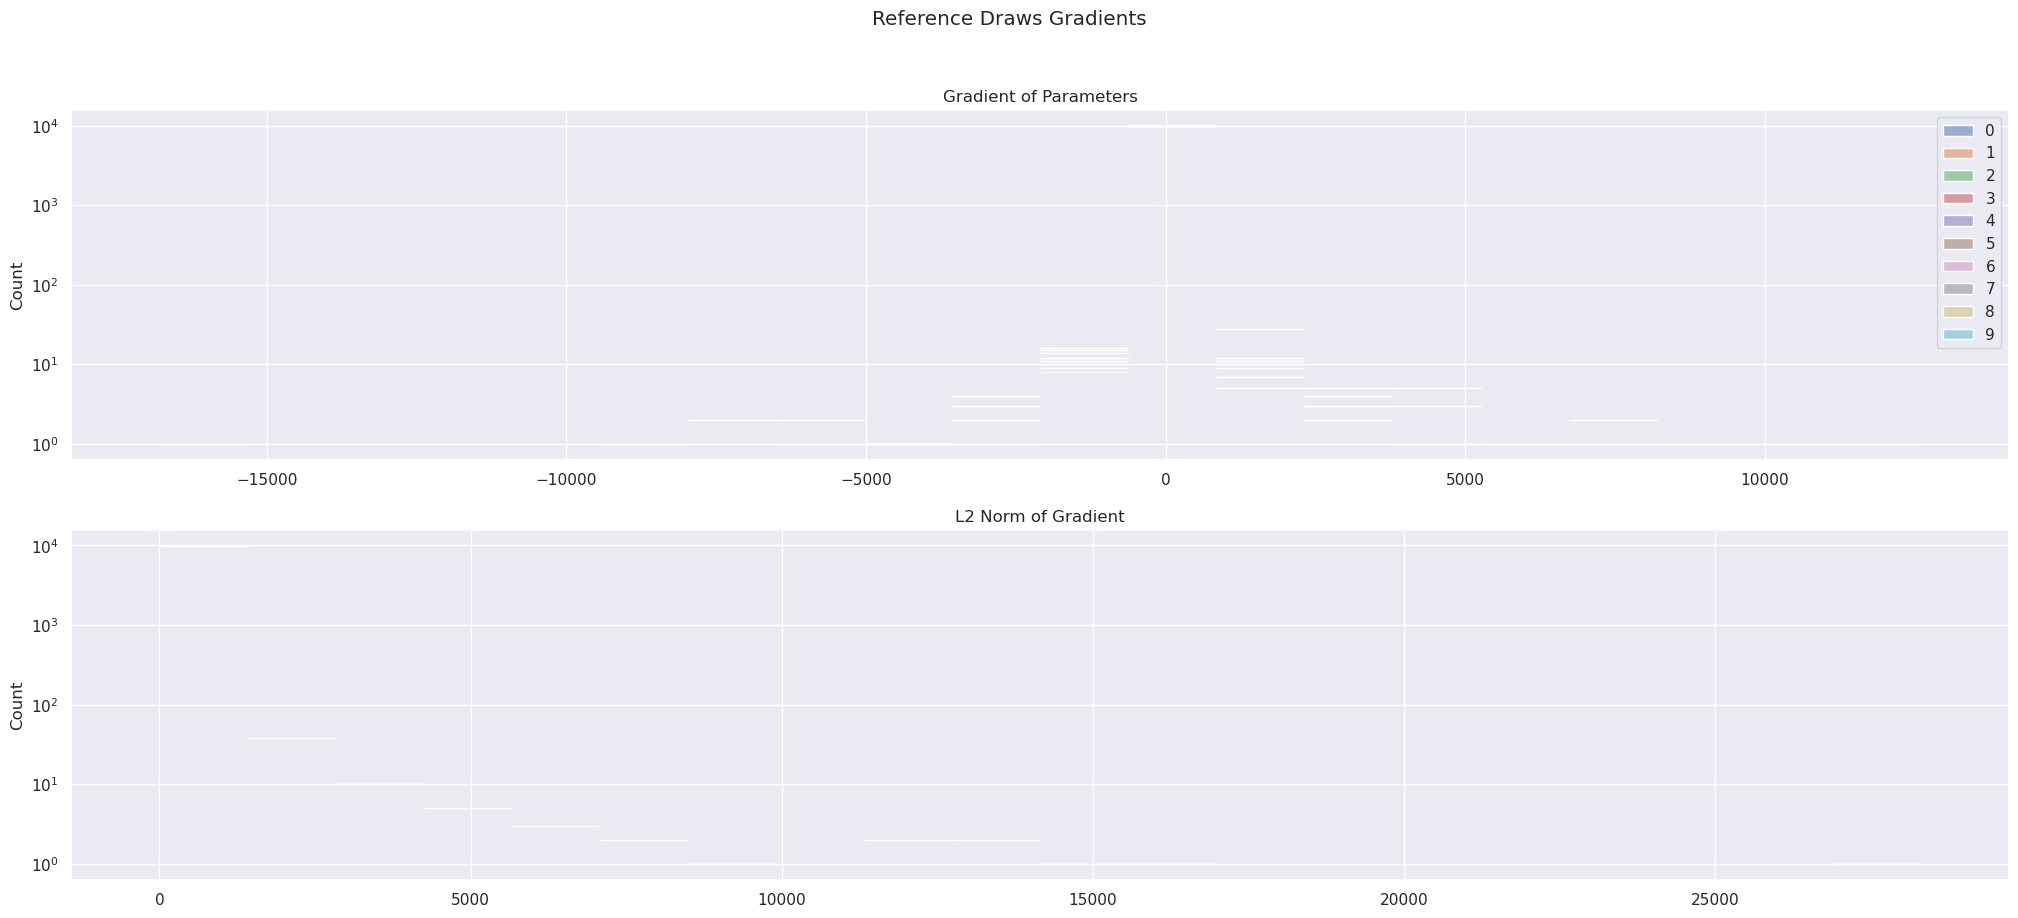

In [9]:
tmp = grad_list[:, :]

fig, ax = plt.subplots(nrows=2, figsize=(25, 10), sharex=False)
sns.histplot(data=pd.DataFrame(tmp.T), ax=ax[0], log_scale=(False, True), bins=20)
sns.histplot(data=norms, ax=ax[1], log_scale=(False, True), bins=20)

ax[0].set_title("Gradient of Parameters")
ax[1].set_title("L2 Norm of Gradient")
fig.suptitle("Reference Draws Gradients")


# Nuts


In [ ]:
model, data, seed, init, inv_metric = stan_nuts(hp)
nuts_fit = model.sample(
    data=data,
    chains=1,
    seed=seed,
    inits=init,
    # metric=inv_metric,
    adapt_init_phase=0  # b/c init from reference draw, already converged to typical set
)
draws = nuts_fit.draws(concat_chains=True)[:, 7:]

In [ ]:
nuts_fit.metric 

In [ ]:
nuts_fit._step_size

In [ ]:
fig = sns.displot(
    kind="hist",
    data=draws[:, 0],
    aspect=1,
    stat="density",
    element="step",
    kde=True,
    bins=50
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# DR-G-HMC

In [ ]:
sp = SamplerParamsTuple(
    sampler_type=drghmc,
    init_stepsize=2,
    reduction_factor=4,
    steps="const_traj_len",
    dampening=0.05,
    num_proposals=3,
    probabilistic=False,
)

sampler = drghmc(hp, sp)
sampler._model.log_density_gradient = grad_counter(
        sampler._model.log_density_gradient
    )

print(sampler._leapfrog_step_sizes, "\n", sampler._leapfrog_step_counts, "\n", sampler._metric)

In [ ]:
draws1 = []
while sampler._model.log_density_gradient.calls < hp.grad_evals:
    draw, logp = sampler.sample()
    draws1.append(draw)
draws1 = np.asanyarray(draws1)

In [ ]:
fig = sns.relplot(
    kind="line",
    data=draws1[:, 0],
    aspect=3
)

fig = sns.displot(
    kind="hist",
    data=draws1[:, 0],
    aspect=2,
    stat="density",
    element="step",
    kde=True,
    bins=400
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# DR-HMC

In [ ]:
sp = SamplerParamsTuple(
    sampler_type=drhmc,
    init_stepsize=2,
    reduction_factor=4,
    steps=0.9,
    num_proposals=3,
    probabilistic=False,
)

sampler = drhmc(hp, sp)
print(sampler._leapfrog_step_sizes, sampler._leapfrog_step_counts)
print(sampler._metric)

In [ ]:
draws2 = []
for idx in range(hp.chain_len * 10):
    print("\n", "*"*40, f" Draw {idx} ", "*"*40)
    draw, logp = sampler.sample()
    draws2.append(draw)
draws2 = np.asanyarray(draws2)

In [ ]:
fig = sns.relplot(
    kind="line",
    data=draws2[:, 0],
    aspect=3
)

fig = sns.displot(
    kind="hist",
    data=draws2[:, 0],
    aspect=2,
    stat="density",
    element="step",
    kde=True,
    bins=400
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# G-HMC

In [ ]:
sp = SamplerParamsTuple(
    sampler_type=ghmc,
    init_stepsize=1,
    dampening=0.05,
)

sampler = ghmc(hp, sp)
print(sampler._leapfrog_step_sizes, sampler._leapfrog_step_counts)
print(sampler._metric)

In [ ]:
draws3 = []
for idx in range(hp.chain_len * 50):
    # print("\n", "*"*40, f" Draw {idx} ", "*"*40)
    draw, logp = sampler.sample()
    draws3.append(draw)
draws3 = np.asanyarray(draws3)

In [ ]:
fig = sns.relplot(
    kind="line",
    data=draws3[:, 0],
    aspect=3
)

fig = sns.displot(
    kind="hist",
    data=draws3[:, 0],
    aspect=2,
    stat="density",
    element="step",
    kde=True,
    bins=300,
    
)

ax = fig.axes[0][0]
ax.set_xlim(-10, 10)

# Summary Statistics and Errors

In [ ]:
print(np.array(ref).mean(), draws.mean(axis=0)[0], draws1.mean(axis=0)[0], draws2.mean(axis=0)[0], draws3.mean(axis=0)[0])

In [ ]:
print(np.square(np.array(ref)).mean(), np.square(draws).mean(axis=0)[0], np.square(draws1).mean(axis=0)[0], np.square(draws2).mean(axis=0)[0], np.square(draws3).mean(axis=0)[0])